In [27]:
import pandas as pd
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt
import requests
import fiona
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Background

- The code in this notebook was originally used to come up with a method ("land area spatial overlap") to distribute the American Community Survey (ACS) data from the Census Tract level to the Election District level in NYC. The land area spatial overlap method calculates how much one level of geographical area shares boundaries with another level of geographical area.
- The ACS information at the election districts can be used to understand what poll sites (made up of a combination of election districts), for example, will benefit most from language interpretation services (data on limited English proficiency (LEP) is one of the variables in the ACS data).
- While this method does not take into account the population density of an area in proportioning data from one area to another, it is still a highly useful and relevant method, especially when the data on population density does not exist or if one area is not a perfect subset of another.
- The code below uses open datasets to demonstrate an open source solution of this method. It can be used to apportion data between any geographic levels. 

#### Packages to install:
- geopandas, pandas, numpy, pyproj, six, fiona, shapely, rtree

#### Geopandas has dependencies and it can be tricky to make all of them work. Recommended installation methods:
1. install using the "conda-forge" community (<code>conda install -c conda-forge geopandas, fiona, shapely, rtree</code>)
2. or create a virtual environment containing OSMnx package (python package to download/analyze geospatial data from OpenStreetMap)

<code>install using conda config --prepend channels conda-forge
conda create -n ox --strict-channel-priority osmnx
activate conda ox
conda install jupyter
jupyter notebook
</code>

### 1. Import Election Districts Data and Census Tracts Data (as of Decennial Census 2010) from the NYC Open Data Portal.

[Election Districts](https://data.cityofnewyork.us/City-Government/Election-Districts/h2n3-98hq): The geographical area used by the NY State Board of Elections to determine placement of poll sites. There are 5,840 election districts that roll up to over 1,000 poll sites in Primary and General election periods in NYC.

[Census Tracts](https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku): The census tracts are small, permanent geographical unit of a county or its geographical equivalent. According to the Census Bureau, the number of people that reside in a census tract is between 1,200 and 8,000. Per Decennial 2010, there are 2,168 census tracts in NYC. 

Analyzing data for smaller geographies can allow for better analysis and census tracts tend to be great in that sense. However, their results should be interpreted with caution when using ACS estimates due to its small sample size.

Variables of interest:
- boro_code: A code associated with each of the five boroughs. (Manhattan = 1, Bronx=2, Brooklyn=3, Queens=4, Staten Island=5)
- boro_ct2010: a unique identifier for each census tract number given that a census tract number may not be unique.
- boro_name: name of one of the five boroughs of NYC
- ct2010: census tract number
- ctlabel: truncated census tract number

### Goal: What is the proportion of area occupied by an election district within a census tract?

### 1.1. Import Election Districts Shapefile (clipped to the shore) from NYC Open Data.  *Source: Decennial Census 2010*

In [28]:
def import_shapefile_and_area_in_sqkm(four_by_four_code):
    '''
    Import a shapefile and calculate the area in square kilometer for each tile. 
    
    Input:
        - four_by_four_code: a string that contains 8 alphanumeric letters assigned 
           to each open dataset on NYC Open Data Portal.
    
    Returns:
        - a geopandas dataframe.
    
    '''
    
    # import the shapefile as GeoJSON from the open data portal
    request = requests.get("https://data.cityofnewyork.us/api/geospatial/" + \
                           four_by_four_code + "?method=export&format=GeoJSON")
    
    visz = fiona.ogrext.buffer_to_virtual_file(bytes(request.content))
    
    # read the features from a fiona collection into a GeoDataFrame
    with fiona.Collection(visz, driver='GeoJSON') as f:
        nyc_opendata_gpd = geopandas.GeoDataFrame.from_features(f, crs=f.crs)
    
    #***************************************#
    
    #Projection: how should geopandas intepret the coordinates?
    
    print("coordinate reference system of the shapefile: ", nyc_opendata_gpd.crs)
    
    # change projection to Mercator, and then square meter into square kilometer
    
    # source: https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas
    nyc_opendata_gpd['area_in_sqkm'] = nyc_opendata_gpd['geometry'].to_crs({'init': 'epsg:3395'})\
                   .map(lambda p: p.area / 10**6)
    
    #alternative method: convert the cartesian system into an equal projection area
    # nyc_opendata_gpd['area_in_sqkm_cea'] = nyc_opendata_gpd['geometry'].to_crs({'proj':'cea'})
    
    return nyc_opendata_gpd

![Some Projections](img/projections.jpg)

In [29]:
ed_nyc_od_gpd = import_shapefile_and_area_in_sqkm("h2n3-98hq")

C:\Users\FAhmed\AppData\Local\Continuum\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\FAhmed\AppData\Local\Continuum\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


coordinate reference system of the shapefile:  +init=epsg:4326 +type=crs


In [30]:
ed_nyc_od_gpd.head()

geometry elect_dist  \
0  MULTIPOLYGON (((-73.91701 40.55634, -73.91626 ...      23001   
1  MULTIPOLYGON (((-73.92033 40.56223, -73.92037 ...      23002   
2  MULTIPOLYGON (((-73.88313 40.56838, -73.88281 ...      23003   
3  MULTIPOLYGON (((-73.86495 40.56663, -73.86509 ...      23004   
4  MULTIPOLYGON (((-73.85901 40.57799, -73.85976 ...      23005   

      shape_area     shape_leng  area_in_sqkm  
0  26134716.3221  25826.4985864         4.194  
1  5637462.91598  13932.1304559         0.905  
2  25240784.1746  42767.2955629         4.051  
3  15150588.9605  27563.6352913         2.432  
4  6169616.81637  16350.3899998         0.991

In [31]:
# number of unique ED's
ed_nyc_od_gpd['elect_dist'].nunique()

5840

Plot the map.

Text(0.5, 1.0, 'Election Districts of NYC as of June 2021')

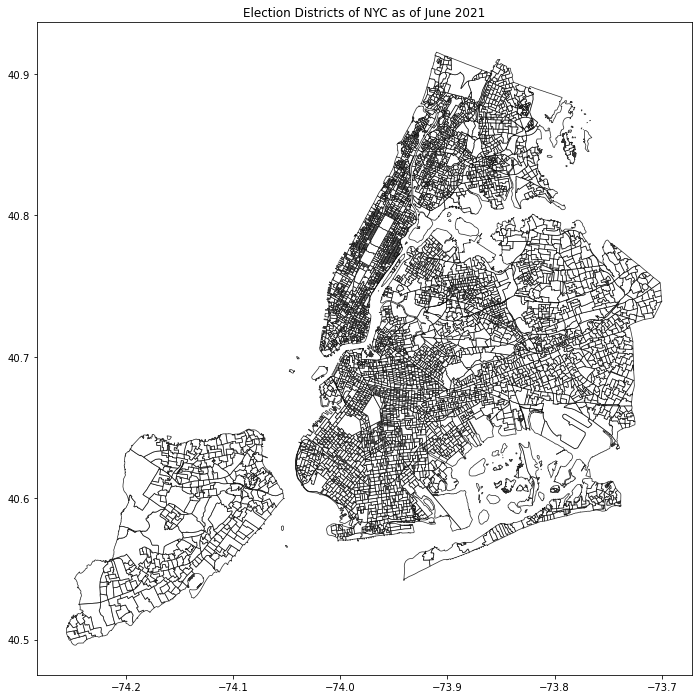

In [32]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_aspect('equal')

ed_nyc_od_gpd.plot(ax=ax, color='white', edgecolor='black', linewidth=0.75, alpha=0.8)

plt.title("Election Districts of NYC as of June 2021")

### 1.2. Import Census Tracts Shapefile from NYC Open Data. *Source: Decennial Census 2010*

In [33]:
census_tracts_2010_gpd = import_shapefile_and_area_in_sqkm("fxpq-c8ku")

C:\Users\FAhmed\AppData\Local\Continuum\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\FAhmed\AppData\Local\Continuum\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


coordinate reference system of the shapefile:  +init=epsg:4326 +type=crs


In [34]:
census_tracts_2010_gpd.shape

(2165, 13)

In [35]:
census_tracts_2010_gpd.head()

geometry ntacode     shape_area  \
0  MULTIPOLYGON (((-74.07921 40.64343, -74.07914 ...    SI22  2497009.71359   
1  MULTIPOLYGON (((-73.96433 40.75638, -73.96479 ...    MN19  1906016.42354   
2  MULTIPOLYGON (((-73.97124 40.76094, -73.97170 ...    MN17  1860992.70485   
3  MULTIPOLYGON (((-73.97446 40.76229, -73.97491 ...    MN17  1864600.37503   
4  MULTIPOLYGON (((-73.98412 40.75484, -73.98460 ...    MN17   1890907.3117   

                                     ntaname     shape_leng      boro_name  \
0  West New Brighton-New Brighton-St. George  7729.01679383  Staten Island   
1                    Turtle Bay-East Midtown  5534.20030628      Manhattan   
2                      Midtown-Midtown South  5687.80243866      Manhattan   
3                      Midtown-Midtown South  5693.03636655      Manhattan   
4                      Midtown-Midtown South  5699.86071223      Manhattan   

   puma  ct2010 boro_code cdeligibil boro_ct2010 ctlabel  area_in_sqkm  
0  3903  000900         5          E     5000900       9         0.402  
1  3808  009800         1          I     1009800      98         0.308  
2  3807  010200         1          I     1010200     102         0.300  
3  3807  010400         1          I     1010400     104         0.301  
4  3807  011300         1          I     1011300     113         0.305

Plot the map.

Text(0.5, 1.0, 'Census Tracts of NYC - Decennial Census 2010')

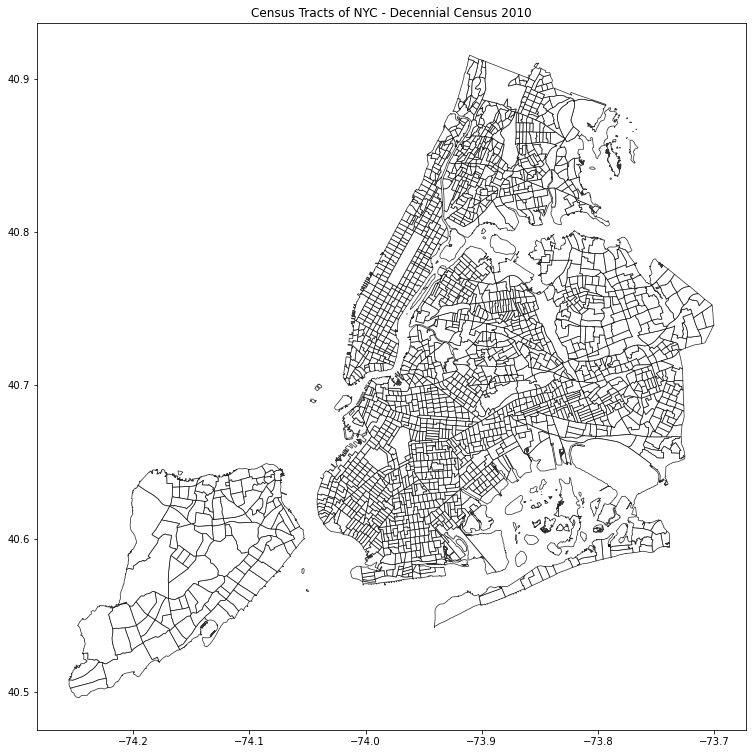

In [36]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.set_aspect('equal')
census_tracts_2010_gpd.plot(ax=ax, color='white', edgecolor='black', linewidth=0.75, alpha=0.8)
plt.title("Census Tracts of NYC - Decennial Census 2010")

In [37]:
census_tracts_2010_gpd.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
census_tracts_2010_gpd.shape

(2165, 13)

### 2. *Overlay* both Election Districts and Census Tracts shapefiles

From Geopandas [documentation](https://geopandas.org/gallery/overlays.html) on overlaying geographical areas:

"Spatial overlays allow you to compare two GeoDataFrames containing polygon or multipolygon geometries and create a new GeoDataFrame with the new geometries representing the spatial combination and merged properties."

![Overlay Methods](img/overlay.jpg)

In [39]:
#join on left (how much area in the left level occupies on the right level)
eds_to_tracts_intersection = geopandas.overlay(ed_nyc_od_gpd, census_tracts_2010_gpd, how='intersection')

C:\Users\FAhmed\AppData\Local\Temp/ipykernel_15580/17927583.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 14558 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  eds_to_tracts_intersection = geopandas.overlay(ed_nyc_od_gpd, census_tracts_2010_gpd, how='intersection')


In [40]:
eds_to_tracts_intersection.head(3)

elect_dist   shape_area_1   shape_leng_1  area_in_sqkm_1 ntacode  \
0      23001  26134716.3221  25826.4985864           4.194    QN10   
1      23002  5637462.91598  13932.1304559           0.905    QN10   
2      23003  25240784.1746  42767.2955629           4.051    QN10   

    shape_area_2                                            ntaname  \
0  47010830.9374  Breezy Point-Belle Harbor-Rockaway Park-Broad ...   
1  47010830.9374  Breezy Point-Belle Harbor-Rockaway Park-Broad ...   
2  47010830.9374  Breezy Point-Belle Harbor-Rockaway Park-Broad ...   

    shape_leng_2 boro_name  puma  ct2010 boro_code cdeligibil boro_ct2010  \
0  48464.8653281    Queens  4114  091601         4          I     4091601   
1  48464.8653281    Queens  4114  091601         4          I     4091601   
2  48464.8653281    Queens  4114  091601         4          I     4091601   

  ctlabel  area_in_sqkm_2                                           geometry  
0  916.01           7.545  POLYGON ((-73.91626 40.55197, -73.91701 40.551...  
1  916.01           7.545  MULTIPOLYGON (((-73.92037 40.56222, -73.92020 ...  
2  916.01           7.545  POLYGON ((-73.88281 40.56767, -73.88277 40.567...

Text(0.5, 1.0, 'Map of Election Districts (green border) and Census Tracts (white border) Overlapped')

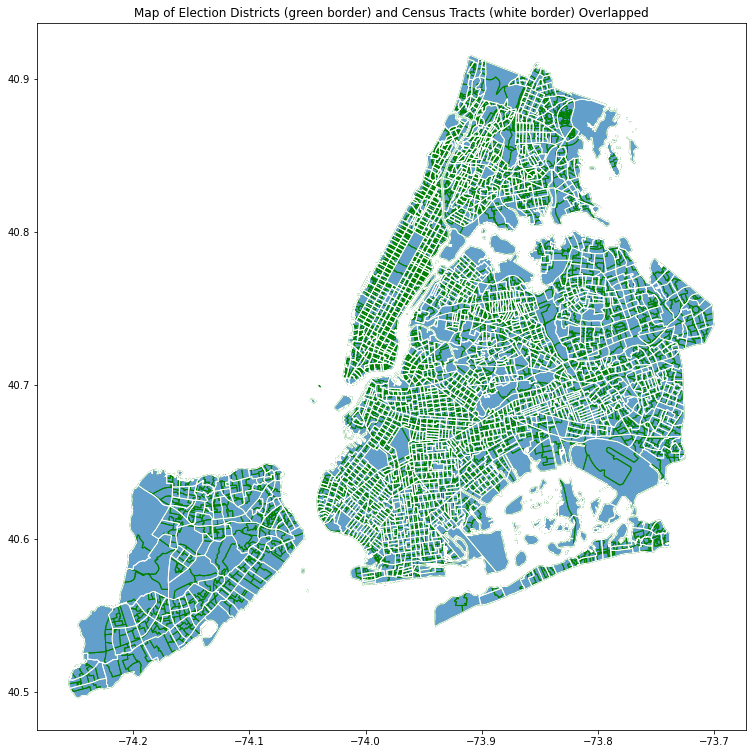

In [41]:
ax = eds_to_tracts_intersection.plot(alpha=0.7, figsize=(13, 13))

ed_nyc_od_gpd.plot(ax=ax, facecolor='none', edgecolor='g')
census_tracts_2010_gpd.plot(ax=ax, facecolor='none', edgecolor='w')

plt.title("Map of Election Districts (green border) and Census Tracts (white border) Overlapped")

If there were any areas that were not filled with blue color, that would indicate that there's no overlapping boundaries between census tracts and election districts.

### 3. After overlaying, calculate the intersection area into square km and identify the election district-to-tract ratio

In [42]:
# calculate intersection area into square km
eds_to_tracts_intersection['intersection_sqkm'] = \
                eds_to_tracts_intersection['geometry'].to_crs({'init': 'epsg:3395'})\
               .map(lambda p: p.area / 10**6)

C:\Users\FAhmed\AppData\Local\Continuum\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [43]:
eds_to_tracts_intersection.head()

elect_dist   shape_area_1   shape_leng_1  area_in_sqkm_1 ntacode  \
0      23001  26134716.3221  25826.4985864           4.194    QN10   
1      23002  5637462.91598  13932.1304559           0.905    QN10   
2      23003  25240784.1746  42767.2955629           4.051    QN10   
3      23004  15150588.9605  27563.6352913           2.432    QN10   
4      23003  25240784.1746  42767.2955629           4.051    QN99   

    shape_area_2                                            ntaname  \
0  47010830.9374  Breezy Point-Belle Harbor-Rockaway Park-Broad ...   
1  47010830.9374  Breezy Point-Belle Harbor-Rockaway Park-Broad ...   
2  47010830.9374  Breezy Point-Belle Harbor-Rockaway Park-Broad ...   
3  47010830.9374  Breezy Point-Belle Harbor-Rockaway Park-Broad ...   
4  13697953.2711                           park-cemetery-etc-Queens   

    shape_leng_2 boro_name  puma  ct2010 boro_code cdeligibil boro_ct2010  \
0  48464.8653281    Queens  4114  091601         4          I     4091601   
1  48464.8653281    Queens  4114  091601         4          I     4091601   
2  48464.8653281    Queens  4114  091601         4          I     4091601   
3  48464.8653281    Queens  4114  091601         4          I     4091601   
4  17693.7089544    Queens  4114  091602         4          I     4091602   

  ctlabel  area_in_sqkm_2                                           geometry  \
0  916.01           7.545  POLYGON ((-73.91626 40.55197, -73.91701 40.551...   
1  916.01           7.545  MULTIPOLYGON (((-73.92037 40.56222, -73.92020 ...   
2  916.01           7.545  POLYGON ((-73.88281 40.56767, -73.88277 40.567...   
3  916.01           7.545  MULTIPOLYGON (((-73.88975 40.56575, -73.88987 ...   
4  916.02           2.199  MULTIPOLYGON (((-73.88955 40.56564, -73.88942 ...   

   intersection_sqkm  
0              4.194  
1              0.905  
2              2.359  
3              0.088  
4              1.693

Add a metric to show a) the proportion of a single ED that falls in a census tract

In [44]:
eds_to_tracts_intersection['elect_dist_area_percent_of_tract_km'] = \
    eds_to_tracts_intersection['intersection_sqkm']/eds_to_tracts_intersection['area_in_sqkm_2']

Rearrange the order of the dataframe by borough, census tract and the election district.

In [45]:
eds_to_tracts_intersection_groupby = eds_to_tracts_intersection.dissolve(
    by=['boro_name', 'boro_ct2010', 'ct2010', 'elect_dist'],
    aggfunc='sum'
    ).reset_index()

In [46]:
eds_to_tracts_intersection_groupby.shape

(15092, 9)

In [47]:
eds_to_tracts_intersection_groupby.head()

boro_name boro_ct2010  ct2010 elect_dist  \
0     Bronx     2000100  000100      85035   
1     Bronx     2000100  000100      85079   
2     Bronx     2000200  000200      85002   
3     Bronx     2000200  000200      85003   
4     Bronx     2000200  000200      85004   

                                            geometry  area_in_sqkm_1  \
0  POLYGON ((-73.87288 40.78596, -73.87298 40.785...           2.933   
1  MULTIPOLYGON (((-73.89069 40.79771, -73.89067 ...           0.002   
2  POLYGON ((-73.85546 40.80997, -73.85531 40.809...           0.520   
3  MULTIPOLYGON (((-73.85484 40.80737, -73.85484 ...           0.271   
4  MULTIPOLYGON (((-73.85682 40.81251, -73.85613 ...           0.603   

   area_in_sqkm_2  intersection_sqkm  elect_dist_area_percent_of_tract_km  
0           2.936              2.933                                0.999  
1           2.936              0.002                                0.001  
2           0.810              0.399                                0.492  
3           0.810              0.000                                0.000  
4           0.810              0.003                                0.004

Perform a quick QA to check that the proportions of a all ED's sum up to 1 (i.e. 100%). If it does, then it shows that all the ED's of NYC are completely mapped to one or more census tracts

In [48]:
election_district_proportions_QA = eds_to_tracts_intersection_groupby\
    .groupby(['boro_ct2010'])['elect_dist_area_percent_of_tract_km'].sum().reset_index()\
    .sort_values('elect_dist_area_percent_of_tract_km', ascending=True)

In [49]:
election_district_proportions_QA.head()

boro_ct2010  elect_dist_area_percent_of_tract_km
0        1000100                                0.465
1090     3053900                                1.000
168      1016200                                1.000
1227     3079802                                1.000
703      3011000                                1.000

In [50]:
# subtracting 0.01 from the lower bound and adding 0.01 to upper bound to account for rounding issues in "elect_dist_area_percent_as_a_whole_km"
election_district_proportions_QA[(election_district_proportions_QA['elect_dist_area_percent_of_tract_km'] < 0.99) | \
                                 (election_district_proportions_QA['elect_dist_area_percent_of_tract_km'] > 1.01)]

boro_ct2010  elect_dist_area_percent_of_tract_km
0     1000100                                0.465

Given the search results are empty, it shows that all election districts were able to map completely to the census tracts.

### 4. Demo: Plot the intersection areas of sample neighborhood to show how the data can be distributed to a different geographic level

Prospect Heights is a neighborhood in Brooklyn

In [51]:
prospect_heights_ed = ed_nyc_od_gpd[ed_nyc_od_gpd['elect_dist'].isin(['57071'])]
prospect_heights_census_tracts = census_tracts_2010_gpd[census_tracts_2010_gpd['ntaname'] == 'Prospect Heights']

#intersect the two election districts with census tracts of Prospect Heights
prospect_heights_ed_and_tracts_intersection = geopandas.overlay(prospect_heights_ed, \
                                                                prospect_heights_census_tracts, how='intersection')

C:\Users\FAhmed\AppData\Local\Temp/ipykernel_15580/3314311163.py:5: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  prospect_heights_ed_and_tracts_intersection = geopandas.overlay(prospect_heights_ed, \


C:\Users\FAhmed\AppData\Local\Temp/ipykernel_15580/3429075396.py:9: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  prospect_heights_census_tracts.apply(lambda x: ax.annotate(s=x['boro_ct2010'], \
C:\Users\FAhmed\AppData\Local\Continuum\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\FAhmed\AppData\Local\Temp/ipykernel_15580/3429075396.py:24: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  lambd

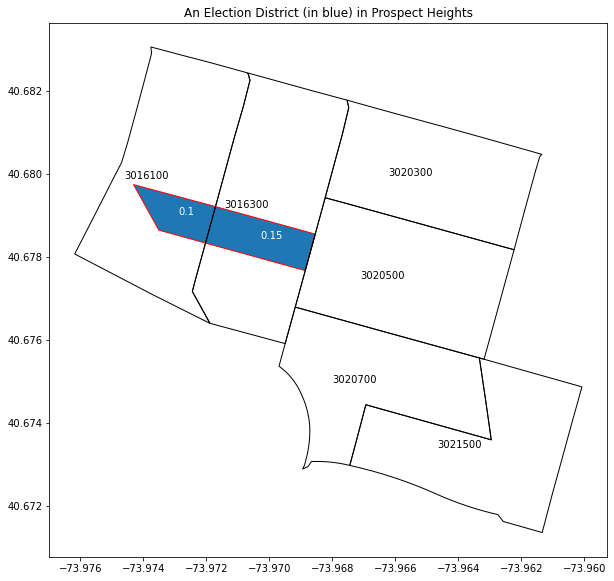

In [52]:
ax = prospect_heights_ed_and_tracts_intersection.plot(figsize=(10, 10))

# plot the ED's and census tracts of Prospect Heights
prospect_heights_ed.plot(ax=ax, facecolor='none', edgecolor='r')

prospect_heights_census_tracts.plot(ax=ax, facecolor='none', edgecolor='k')
plt.title("An Election District (in blue) in Prospect Heights")

prospect_heights_census_tracts.apply(lambda x: ax.annotate(s=x['boro_ct2010'], \
        xy=x.geometry.centroid.coords[0], ha='right'),axis=1);

# Calculate the intersection area of election districts and census tracts in square kilometer
prospect_heights_ed_and_tracts_intersection['intersection_sqkm'] = \
        prospect_heights_ed_and_tracts_intersection['geometry'].to_crs({'init': 'epsg:3395'})\
       .map(lambda p: p.area / 10**6)

# calculate the metrics that show proportion of each election district and census tract 
prospect_heights_ed_and_tracts_intersection['elect_dist_area_percent_of_tract_km'] = \
        prospect_heights_ed_and_tracts_intersection['intersection_sqkm']/\
        prospect_heights_ed_and_tracts_intersection['area_in_sqkm_2']

#annonate the first metric i.e. "what percent of census tract is occupied by the election district?" on the map
prospect_heights_ed_and_tracts_intersection.apply(\
                lambda x: ax.annotate(s=round(x['elect_dist_area_percent_of_tract_km'], 2),\
                xy=x.geometry.centroid.coords[0], ha='left', color='w'),axis=1);

The visualization above is of one election district (i.e. 57071) in Prospect Heights. In order to apportion the data from the Census Tract 3016300 to the election district, we'll multiply the data by 0.15. That is the share of the census tract area given to that election district.

E.g. If there are 1,500 residents who speak Russian in Census Tract 3016300, then the number of Russian speakers in the Election District 57071 will be 225.